In [ ]:
# !pip install fbprophet

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

## 데이터 로드

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data/공돌이 용달_stat.csv'
df = pd.read_csv(path, header=0)
print(df.shape)
print(df.head())

(465, 6)
   searchDate  dailyViewCount  ...  favorablePercent  activePercent
0  2019-11-14          138527  ...                96             93
1  2019-11-15          447397  ...                96             93
2  2019-11-16          474562  ...                96             93
3  2019-11-17          223403  ...                96             93
4  2019-11-18          298252  ...                96             93

[5 rows x 6 columns]


## 불필요한 컬럼 삭제(단변량 예측)

In [ ]:
del df['dailyViewCount']
del df['videoCount']
del df['favorablePercent']
del df['activePercent']

In [ ]:
# 데이터의 마지막 날짜와 그 다음 날짜를 저장
lastday = df['searchDate'][len(df)-1]
nextday = str(pd.date_range(lastday, periods=2)[1])[:10]
print("마지막 날짜 : {}, 예측 시작 날짜 : {}".format(lastday, nextday))

마지막 날짜 : 2021-02-21, 예측 시작 날짜 : 2021-02-22


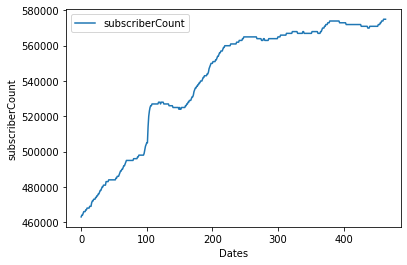

In [ ]:
df.plot()
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.show()

## 모델에 맞게 데이터 전처리

In [ ]:
# 컬럼명 변경
df.columns = ['ds', 'y']
# 데이터 타입 변경
df['ds']= pd.to_datetime(df['ds'])

In [ ]:
preday = 30

In [ ]:
fast_10day = str(pd.date_range(df['ds'][len(df)-preday], periods=preday)[0])[:10]

In [ ]:
y_true = df['y'][-preday:].values

# train set 마지막 preday일 날짜 예측 검증
last_10day = list()
for i in range(preday):
    last_10day.append(str(pd.date_range(fast_10day, periods=preday)[i])[:10])
last_10day = pd.DataFrame(last_10day, columns = ['ds'])
last_10day['ds']= pd.to_datetime(last_10day['ds'])

In [ ]:
from fbprophet import Prophet

# 모델 생성
model = Prophet()
# 모델 학습
model.fit(df)

forecast = model.predict(last_10day)
y_pred = forecast['yhat'].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


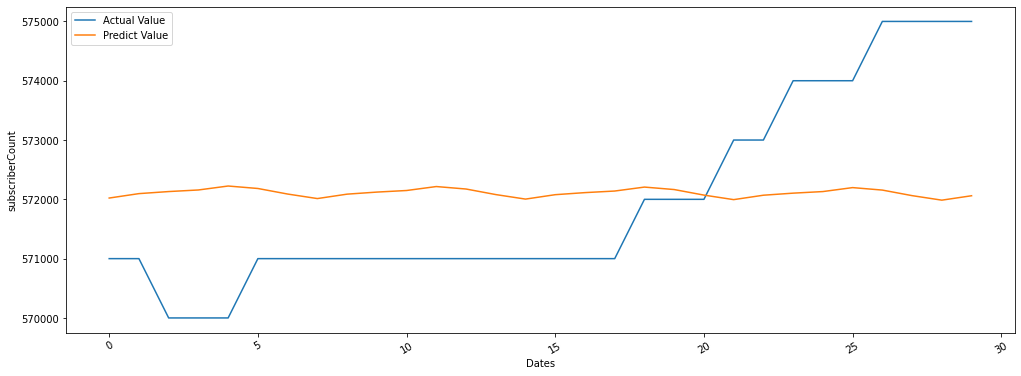

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(y_true, label="Actual Value")
plt.plot(y_pred, label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(rotation = 30)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('prophet - MAE 값 : %.3f' % mae)

prophet - MAE 값 : 1425.385


## 예측할 일 수 입력

In [ ]:
# 예측할 날짜 일 수
predict_day = 9
# 예측 날짜 문자열 리스트 생성
pred_date = list()
for i in range(predict_day):
    pred_date.append(str(pd.date_range(nextday, periods=predict_day)[i])[:10])

# 날짜 리스트를 데이터 프레임 화
pred_date = pd.DataFrame(pred_date, columns = ['ds'])
# 문자열을 날짜 데이터 형식으로 변환
pred_date['ds']= pd.to_datetime(pred_date['ds'])

## 시각화

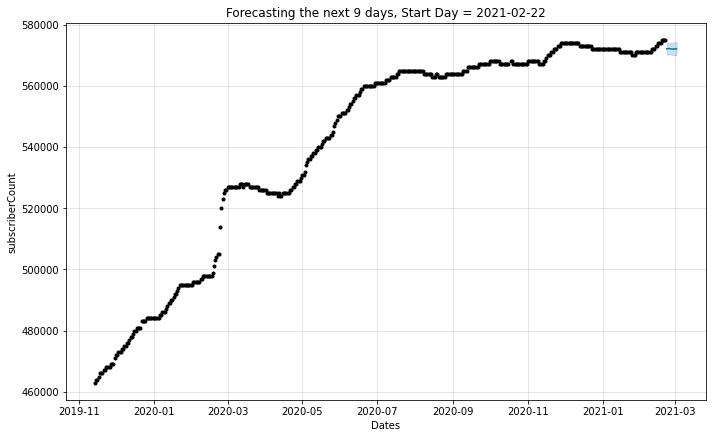

In [ ]:
# 미래 예측
forecast = model.predict(pred_date)
model.plot(forecast)
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {predict_day} days, Start Day = {nextday}")
plt.show()

In [ ]:
# 기존 데이터 마지막 날의 다음 날을 구함(= 미래 예측 데이터의 시작 날짜)
next = str(pd.date_range(df['ds'][len(df)-1], periods=2)[1])[:10]

step = 9
# 예측 데이터 날짜 리스트 생성
forecast_date = []
for i in range(step):
  forecast_date.append(str(pd.date_range(next, periods=step)[i])[:10])

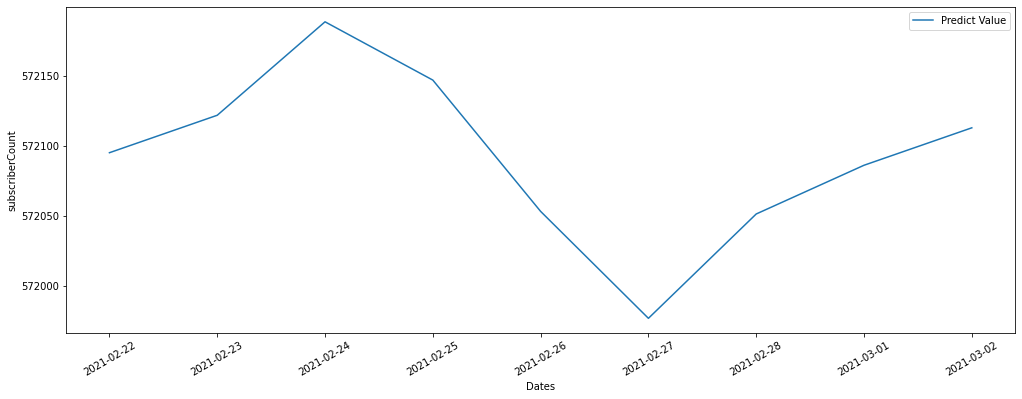

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(forecast['yhat'], label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(list(range(step)), forecast_date, rotation = 30)
plt.legend()
plt.show()

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-22,572094.615760,570231.197981,574016.536156,572094.615760,572094.615760,0.707807,0.707807,0.707807,0.707807,0.707807,0.707807,0.0,0.0,0.0,572095.323567
1,2021-02-23,572093.336470,570258.686984,573933.744956,572093.336470,572093.336470,28.712864,28.712864,28.712864,28.712864,28.712864,28.712864,0.0,0.0,0.0,572122.049333
2,2021-02-24,572092.057179,570305.009966,574134.934004,572092.057179,572092.057179,96.698024,96.698024,96.698024,96.698024,96.698024,96.698024,0.0,0.0,0.0,572188.755203
3,2021-02-25,572090.777889,570237.013145,574025.407240,572081.201610,572090.777889,56.373580,56.373580,56.373580,56.373580,56.373580,56.373580,0.0,0.0,0.0,572147.151469
4,2021-02-26,572089.498598,570218.561791,574073.062403,572018.539991,572156.341724,-36.055001,-36.055001,-36.055001,-36.055001,-36.055001,-36.055001,0.0,0.0,0.0,572053.443597
5,2021-02-27,572088.219307,570054.503166,573947.218440,571935.489710,572287.871340,-111.092113,-111.092113,-111.092113,-111.092113,-111.092113,-111.092113,0.0,0.0,0.0,571977.127194
6,2021-02-28,572086.940017,569992.741232,574197.637176,571844.417558,572355.090982,-35.345160,-35.345160,-35.345160,-35.345160,-35.345160,-35.345160,0.0,0.0,0.0,572051.594856
7,2021-03-01,572085.660726,570048.703467,574266.751054,571722.095656,572500.203743,0.707807,0.707807,0.707807,0.707807,0.707807,0.707807,0.0,0.0,0.0,572086.368533
8,2021-03-02,572084.381435,570042.261634,574256.443372,571544.098277,572662.319724,28.712864,28.712864,28.712864,28.712864,28.712864,28.712864,0.0,0.0,0.0,572113.094299


In [ ]:
# yhat은 미래 예측 값, yhat_lower은 예측 하한값, yhat_upper은 예측 상한값
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

          ds           yhat     yhat_lower     yhat_upper
0 2021-02-22  572095.323567  570231.197981  574016.536156
1 2021-02-23  572122.049333  570258.686984  573933.744956
2 2021-02-24  572188.755203  570305.009966  574134.934004
3 2021-02-25  572147.151469  570237.013145  574025.407240
4 2021-02-26  572053.443597  570218.561791  574073.062403
5 2021-02-27  571977.127194  570054.503166  573947.218440
6 2021-02-28  572051.594856  569992.741232  574197.637176
7 2021-03-01  572086.368533  570048.703467  574266.751054
8 2021-03-02  572113.094299  570042.261634  574256.443372


In [ ]:
arr = forecast['yhat']

In [ ]:
int(arr[0])

572095

In [ ]:
for i in arr :
  print(int(i))

572095
572122
572188
572147
572053
571977
572051
572086
572113
